In [1]:
%cd ~/mechanistic-unlearning
%load_ext autoreload
%autoreload 2
import functools
import os
import gc
import json
from tkinter import font
import sys
from collections import defaultdict
from dataset.custom_dataset import PairedInstructionDataset
import torch

from transformer_lens import HookedTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset
import einops
from transformer_lens import ActivationCache
import time
import pandas as pd
# project_root = os.path.abspath(os.path.dirname(__file__))
project_root = "/data/phillip_guo/mechanistic-unlearning"

# Add the project root and its subdirectories to the Python path
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'masks_learning'))
sys.path.insert(0, os.path.join(project_root, 'localizations'))
sys.path.insert(0, os.path.join(project_root, 'tasks'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/data/phillip_guo/mechanistic-unlearning


In [2]:
model = HookedTransformer.from_pretrained(
    'google/gemma-2-9b',
    device='cuda',
    default_padding_side="left",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)
tokenizer = model.tokenizer

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
hf_model = AutoModelForCausalLM.from_pretrained("google/gemma-2-9b", torch_dtype=torch.bfloat16, attn_implementation="eager")
# hf_model.cuda()
right_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b", padding_side="right")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
import datasets
qlm_grader_last_dataset = datasets.load_dataset("EleutherAI/qm-grader-last")
train_qlm_last_df = qlm_grader_last_dataset['train'].to_pandas()
train_qlm_last_df.query("character == 'Alice'")

,alice_label,bob_label,difficulty,statement,choices,character,label
0,False,False,2,87 + 38 = 245. Alice:,"[ False, True]",Alice,0
2,False,False,4,98682 + 3101 = 291783. Alice:,"[ False, True]",Alice,0
4,True,False,2,818 + 36 = 854. Alice:,"[ False, True]",Alice,1
6,False,True,3,480 + 15363 = 25843. Alice:,"[ False, True]",Alice,0
8,False,True,2,30 + 14 = 54. Alice:,"[ False, True]",Alice,0
...,...,...,...,...,...,...,...
399990,True,False,4,1547 + 2789 = 4336. Alice:,"[ False, True]",Alice,1
399992,False,True,1,1 + 9610 = 10611. Alice:,"[ False, True]",Alice,0
399994,True,False,4,2594 + 6225 = 8819. Alice:,"[ False, True]",Alice,1
399996,False,False,1,6 + 23474 = 23490. Alice:,"[ False, True]",Alice,0


## Regenerate dataset, easier examples

In [ ]:
mixture_dataset = load_dataset("EleutherAI/qm-mixture", split='train').to_pandas()
mixture_dataset.query("character == 'Alice'")["statement"].head(20).tolist()

In [ ]:
import random
import json

# Function to convert numbers to words
def number_to_words(number):
    if number < 0:
        return "minus " + number_to_words(-number)
    words = []
    units = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    teens = ["", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]
    tens = ["", "ten", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]
    thousands = ["", "thousand", "million", "billion", "trillion"]

    if number == 0:
        return "zero"

    num_str = str(number)
    num_len = len(num_str)

    # Iterate over the digits in reverse, building words
    for i in range(num_len):
        digit = int(num_str[num_len - i - 1])
        if i % 3 == 0:  # Handle units
            if i > 0 and digit != 0:
                words.append(thousands[i // 3])
            if digit != 0 or (i == 0 and len(words) == 0):
                words.append(units[digit])
        elif i % 3 == 1:  # Handle tens
            if digit == 1 and i > 0 and int(num_str[num_len - i]) != 0:  # Handle teens
                words.pop()
                words.append(teens[int(num_str[num_len - i])])
            else:
                words.append(tens[digit])
        elif i % 3 == 2:  # Handle hundreds
            if digit != 0:
                words.append("hundred")
                words.append(units[digit])

    return " ".join(reversed(words))

# Helper function to create plausible false answers
def generate_false_answer(true_answer, num_digits_off):
    """
    Given true_answer (int), false answer should be off on num_digits different digits.
    For each digit in true_answer, randomly choose a different digit to be the false answer, without replacement.
    """
    true_answer_str = str(true_answer)
    false_answer_list = list(true_answer_str)
    if num_digits_off == -1:
        num_digits_off = len(true_answer_str)
    digits_to_change = random.sample(range(len(true_answer_str)), num_digits_off)
    
    for index in digits_to_change:
        current_digit = int(false_answer_list[index])
        new_digit = random.choice([d for d in range(10) if d != current_digit])
        false_answer_list[index] = str(new_digit)
    
    false_answer = int(''.join(false_answer_list))
    return false_answer

question_formats = {
    "standard": "{operand1_str} + {operand2_str} = {answer_str}. Answer:",
    "vanilla": "{operand1_str} plus {operand2_str} equals {answer_str}. Answer:",
    "teacher": 'Teacher: "Is {operand1_str} + {operand2_str} = {answer_str}?"\n\nAnswer:',
    "ain't": "{operand1_str} + {operand2_str} = {answer_str} ain't",
    "does": 'Does {operand1_str} + {operand2_str} = {answer_str}? Answer:',
    "student": "Student:\n\n{operand1_str} + {operand2_str} = {answer_str}\n\nScore:",
    "exam": "Exam 1\n\nPart 1: True or False\n\n1. {operand1_str} + {operand2_str} = {answer_str}\nAnswer:",
}

# Helper function to create the question in different formats
def generate_question_format(question_format, operand1, operand2, answer, use_words=False):
    if use_words:
        operand1_str = number_to_words(operand1)
        operand2_str = number_to_words(operand2)
        answer_str = number_to_words(answer)
    else:
        operand1_str = str(operand1)
        operand2_str = str(operand2)
        answer_str = str(answer)

    question = question_format.format(operand1_str=operand1_str, operand2_str=operand2_str, answer_str=answer_str)
    return question

# Generate dataset
def generate_dataset(num_samples, num_digits_range=range(1, 5), question_formats=question_formats, num_digits_off=None):
    dataset = []
    for num_digits in num_digits_range:
        for _ in range(num_samples):  # generating 1000 samples for the dataset
            datapoint = {}
            operand1 = random.randint(1, 10**num_digits-1)
            operand2 = random.randint(1, 10**num_digits-1)
            answer = operand1 + operand2
            rand_num_digits_off = random.randint(1, len(str(answer))) if num_digits_off is None else num_digits_off
            wrong_answer = generate_false_answer(answer, num_digits_off=rand_num_digits_off)
            datapoint["operand1"] = operand1
            datapoint["operand2"] = operand2
            datapoint["answer"] = answer
            datapoint["wrong_answer"] = wrong_answer
            datapoint["num_digits"] = num_digits
            datapoint["num_digits_off"] = num_digits_off
            datapoint["operand1_str"] = number_to_words(operand1)
            datapoint["operand2_str"] = number_to_words(operand2)
            datapoint["answer_str"] = number_to_words(answer)
            datapoint["wrong_answer_str"] = number_to_words(wrong_answer)

            for question_true in [True, False]:
                for use_words in [True, False]:
                    for question_name, question_format in question_formats.items():
                        if question_name == "ain't":
                            question = generate_question_format(question_format, operand1, operand2, wrong_answer if question_true else answer, use_words=use_words)
                            datapoint[f"question_{question_name}_{'words' if use_words else 'digits'}_{'true' if question_true else 'false'}"] = question
                        else:
                            question = generate_question_format(question_format, operand1, operand2, answer if question_true else wrong_answer, use_words=use_words)
                            datapoint[f"question_{question_name}_{'words' if use_words else 'digits'}_{'true' if question_true else 'false'}"] = question
            dataset.append(datapoint)
    return pd.DataFrame(dataset)
addition_df = generate_dataset(1000, num_digits_off=-1)
# train_df = generate_dataset(10000, num_digits_off=None)
# test_df = generate_dataset(10000, num_digits_off=None)
# icl_dataset = generate_dataset(num_samples=100) # at max 50 shots

# train_df.to_parquet("tasks/qlm/data/addition_train_dataset.parquet")
# test_df.to_parquet("tasks/qlm/data/addition_test_dataset.parquet")
# icl_dataset.to_parquet("tasks/qlm/data/addition_icl_dataset.parquet")


In [ ]:
addition_df.head(2).T

In [ ]:
def get_icl_prompt(template, n_digits, n_shots=10, use_words=False):
    dataset = generate_dataset(num_samples=n_shots, num_digits_range=[n_digits], question_formats={"template": template})
    dataset = dataset.query("num_digits == @n_digits")
    icl_prompt = ""
    for i, row in dataset.iterrows():
        # randomly choose True or False
        question_true = random.choice([True, False])
        question = row[f"question_template_{'words' if use_words else 'digits'}_{'true' if question_true else 'false'}"]
        icl_prompt += f"{question} {'True' if question_true else 'False'}\n\n"
    return icl_prompt

print(get_icl_prompt(question_formats["standard"], n_digits=3, use_words=True))


In [ ]:
# check model accuracy
template_name = "standard"
n_shots = 20
use_words = False
# augment dataset with full prompt
# icl_prompts = {n_digits: get_icl_prompt(question_formats[template_name], n_digits, n_shots, use_words=use_words) for n_digits in range(1, 5)}

# make a prompt Series
def get_prompt_column(row, statement_true=True):
    n_digits = row["num_digits"]
    # return icl_prompts[n_digits] + row[f"question_{template_name}_{'words' if use_words else 'digits'}_{'true' if statement_true else 'false'}"]
    return get_icl_prompt(question_formats[template_name], n_digits, n_shots, use_words=use_words) + row[f"question_{template_name}_{'words' if use_words else 'digits'}_{'true' if statement_true else 'false'}"]

true_prompts = addition_df.apply(lambda row: get_prompt_column(row, statement_true=True), axis=1)
false_prompts = addition_df.apply(lambda row: get_prompt_column(row, statement_true=False), axis=1)

In [ ]:
model.cpu()
torch.cuda.memory_allocated() / 1024**3

In [ ]:
from tasks.inference_utils import get_final_logits
batch_size = 4
true_prompt_logits = []
for prompt_idx in tqdm(range(0, len(true_prompts), batch_size)):
    with torch.no_grad():
        logits = get_final_logits(hf_model, right_tokenizer, true_prompts.iloc[prompt_idx:prompt_idx+batch_size].tolist())
    true_prompt_logits.append(logits)
true_prompt_logits = torch.cat(true_prompt_logits, dim=0)

In [ ]:
true_prompts[:5].tolist()

In [ ]:
false_prompt_logits = []
for prompt_idx in tqdm(range(0, len(false_prompts), batch_size)):
    with torch.no_grad():
        logits = get_final_logits(hf_model, right_tokenizer, false_prompts.iloc[prompt_idx:prompt_idx+batch_size].tolist())
    false_prompt_logits.append(logits)
false_prompt_logits = torch.cat(false_prompt_logits, dim=0)

In [ ]:
answer_df = pd.DataFrame({
    "true_prompts": true_prompts,
    "false_prompts": false_prompts,
    "true_response": tokenizer.batch_decode(true_prompt_logits.argmax(dim=-1)),
    "false_response": tokenizer.batch_decode(false_prompt_logits.argmax(dim=-1)),
    "num_digits": addition_df["num_digits"],
})

In [ ]:
display(answer_df["true_response"].str.contains("True").groupby(answer_df["num_digits"]).mean())
display(answer_df["false_response"].str.contains("False").groupby(answer_df["num_digits"]).mean())

## Test new Task

In [ ]:
from tasks.qlm.AdditionTask import AdditionTask
addition_task = AdditionTask(batch_size=8, tokenizer=right_tokenizer, max_difficulty=2, n_shots=12, use_words=False, template_names=["standard"])
print(addition_task.get_batch(train=True)["label_str"])
print(addition_task.get_test_loss(model, n_iters=5))
print(addition_task.get_test_accuracy(model, check_all_logits=False, continuous=True, n_iters=5))

In [ ]:
from tasks.qlm.AdditionTask import AdditionTask
addition_task = AdditionTask(batch_size=8, tokenizer=right_tokenizer, max_difficulty=2, n_shots=20, use_words=False, template_names=["ain't"])
print(addition_task.get_batch(train=True)["label_str"])
print(addition_task.get_test_loss(model, n_iters=5))
print(addition_task.get_test_accuracy(model, check_all_logits=False, continuous=True, n_iters=5))

## Train Probes

In [5]:
def retrieve_acts(model, prompt_list, batch_size, layer=None, to_cpu=False, truncate_length=None, sequence_pos=None):
    if layer is None:
        caches = defaultdict(list)
    else:
        caches = []
    if isinstance(sequence_pos, int):
        sequence_pos = [sequence_pos] * len(prompt_list)
    elif sequence_pos is None:
        sequence_pos = [-1] * len(prompt_list)
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        attn_mask = tokenized_prompts.attention_mask
        if truncate_length is not None:
            if len(prompt_toks[0]) > truncate_length:
                print(f"Prompt {i} is too long, truncating")
                prompt_toks = prompt_toks[:, -truncate_length:]
                attn_mask = attn_mask[:, -truncate_length:]

        _, cache = model.run_with_cache(
            prompt_toks,
            attention_mask=attn_mask,
            names_filter = (lambda name: f"hook_resid_post" in name) if layer is None else (f"blocks.{layer}.hook_resid_post")
        )
        batch_sequence_pos_index = sequence_pos[i:i+batch_size]

        if layer is None:
            for k, v in cache.items():
                key_layer = int(k.split(".")[1])

                if isinstance(sequence_pos, torch.Tensor) and len(sequence_pos.shape) > 1:
                    batch_index = torch.arange(v.shape[0]).unsqueeze(-1).repeat(1, batch_sequence_pos_index.shape[1])
                else:
                    batch_index = torch.arange(v.shape[0])
                if to_cpu:
                    caches[key_layer].append(v[batch_index, batch_sequence_pos_index, :].cpu())
                else:
                    caches[key_layer].append(v[batch_index, batch_sequence_pos_index, :])
        else:
            if isinstance(sequence_pos, torch.Tensor) and len(sequence_pos.shape) > 1:
                batch_index = torch.arange(cache.shape[0]).unsqueeze(-1).repeat(1, batch_sequence_pos_index.shape[1])
            else:
                batch_index = torch.arange(cache.shape[0])
            if to_cpu:
                caches.append(cache[f"blocks.{layer}.hook_resid_post"][batch_index, batch_sequence_pos_index, :].cpu())
            else:
                caches.append(cache[f"blocks.{layer}.hook_resid_post"][batch_index, batch_sequence_pos_index, :])
    if layer is None:
        for k, v in caches.items():
            caches[k] = torch.cat(v, dim=0)
    else:
        caches = torch.cat(caches, dim=0)
    return caches

In [23]:
from tasks.qlm.AdditionTask import AdditionTask
addition_task = AdditionTask(batch_size=8, tokenizer=right_tokenizer, max_difficulty=4, n_shots=20, use_words=False, template_names=["standard"])
baseline_accuracy = addition_task.get_test_accuracy(model, check_all_logits=False, continuous=False, n_iters=50)
print(baseline_accuracy)
train_df = addition_task.train_dataset.to_pandas().sample(1000)
test_df = addition_task.test_dataset.to_pandas().sample(500)

0.815


In [15]:
import torch

def get_token_sequence_pos(prompt_list, batch_size, token_str):
    token = tokenizer(token_str).input_ids[-1]
    
    last_equal_positions = []
    
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        prompt_len = prompt_toks.shape[1]
        # Create a boolean mask for the equal sign token
        token_mask = (prompt_toks == token)
        
        # Get all occurrences of the equal sign token for each prompt in the batch
        all_token_pos = torch.nonzero(token_mask)
        
        # Group the positions by prompt (row) index
        grouped_pos = [all_token_pos[all_token_pos[:, 0] == row, 1] for row in range(token_mask.shape[0])]
        
        # Get the last position for each prompt, or -1 if not found
        batch_last_pos = [-(prompt_len - pos[-1].item()) if len(pos) > 0 else -1 for pos in grouped_pos]
        # print(prompt_toks.shape, prompt_toks[torch.arange(prompt_toks.shape[0]), batch_last_pos])
        last_equal_positions.extend(batch_last_pos)

    return last_equal_positions

# Test the function
train_equal_sign_positions = torch.tensor(get_token_sequence_pos(train_df["full_prompt"].tolist(), batch_size=100, token_str=" ="))
test_equal_sign_positions = torch.tensor(get_token_sequence_pos(test_df["full_prompt"].tolist(), batch_size=100, token_str=" ="))
train_answer_positions = torch.tensor(get_token_sequence_pos(train_df["full_prompt"].tolist(), batch_size=100, token_str=" Answer"))
test_answer_positions = torch.tensor(get_token_sequence_pos(test_df["full_prompt"].tolist(), batch_size=100, token_str=" Answer"))
print(train_equal_sign_positions.shape)
print(test_equal_sign_positions.shape)
print(train_answer_positions.shape)
print(test_answer_positions.shape)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([1000])
torch.Size([500])
torch.Size([1000])
torch.Size([500])


In [17]:
import pickle
load_acts = True
if load_acts:
    with open(f"experiments/gemma2_9b_manual/addition_activations.pkl", "rb") as f:
        cache = pickle.load(f)
        train_equal_pos_acts = cache["train_equal_pos_acts"]
        train_answer_pos_acts = cache["train_answer_pos_acts"]
        train_last_pos_acts = cache["train_last_pos_acts"]
        test_equal_pos_acts = cache["test_equal_pos_acts"]
        test_answer_pos_acts = cache["test_answer_pos_acts"]
        test_last_pos_acts = cache["test_last_pos_acts"]
else:
    train_sequence_pos = torch.stack([train_equal_sign_positions, train_answer_positions-1, -torch.ones_like(train_equal_sign_positions)], dim=1)
    test_sequence_pos = torch.stack([test_equal_sign_positions, test_answer_positions-1, -torch.ones_like(test_equal_sign_positions)], dim=1)
    with torch.no_grad():
        train_acts = retrieve_acts(model, train_df["full_prompt"].tolist(), batch_size=8, to_cpu=True, sequence_pos=train_sequence_pos)
        test_acts = retrieve_acts(model, test_df["full_prompt"].tolist(), batch_size=8, to_cpu=True, sequence_pos=test_sequence_pos)

    train_equal_pos_acts = {layer: train_acts[layer][:, 0].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    train_answer_pos_acts = {layer: train_acts[layer][:, 1].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    train_last_pos_acts = {layer: train_acts[layer][:, 2].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    test_equal_pos_acts = {layer: test_acts[layer][:, 0].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    test_answer_pos_acts = {layer: test_acts[layer][:, 1].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    test_last_pos_acts = {layer: test_acts[layer][:, 2].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    with open(f"experiments/gemma2_9b_manual/addition_activations.pkl", "wb") as f:
        pickle.dump({"train_equal_pos_acts": train_equal_pos_acts, "train_answer_pos_acts": train_answer_pos_acts, "train_last_pos_acts": train_last_pos_acts, "test_equal_pos_acts": test_equal_pos_acts, "test_answer_pos_acts": test_answer_pos_acts, "test_last_pos_acts": test_last_pos_acts}, f)

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [20]:
import os
import multiprocess as mp
from multiprocessing import Manager
from multiprocessing import Pool
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Trying cpu multiprocessing")
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.preprocessing import StandardScaler
def train_test_probe(X_train, X_test, y_train, y_test, preprocess=True):
    if preprocess:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    clf = LogisticRegression(solver='sag').fit(X_train, y_train)
    # clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
    # results[layer] = clf.score(X_test, y_test)
    return clf.score(X_test, y_test)

results_dict = {}
for pos_type, X_train, X_test, y_train, y_test in [("Answer Token", train_answer_pos_acts, test_answer_pos_acts, train_df["label"].tolist(), test_df["label"].tolist()), ("Last Token", train_last_pos_acts, test_last_pos_acts, train_df["label"].tolist(), test_df["label"].tolist())]:
    results_dict[pos_type] = []
    for layer in tqdm(range(model.cfg.n_layers)):
        results_dict[pos_type].append(train_test_probe(X_train[layer], X_test[layer], y_train, y_test))

# results_dict = {}
# for pos_type, X_train, X_test, y_train, y_test in [("Answer Token", train_answer_pos_acts, test_answer_pos_acts, train_df["label"].tolist(), test_df["label"].tolist()), ("Last Token", train_last_pos_acts, test_last_pos_acts, train_df["label"].tolist(), test_df["label"].tolist())]:
#     start_time = time.time()
#     with ThreadPool(processes=model.cfg.n_layers) as pool:  # Using ThreadPool
#         results = pool.starmap(train_test_probe, [(X_train[layer], X_test[layer], y_train, y_test) for layer in range(model.cfg.n_layers)])
#     end_time = time.time()
#     print(f"Time taken: {end_time - start_time} seconds")
#     print(results)
#     results_dict[pos_type] = results


Trying cpu multiprocessing


  0%|          | 0/42 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

  0%|          | 0/42 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

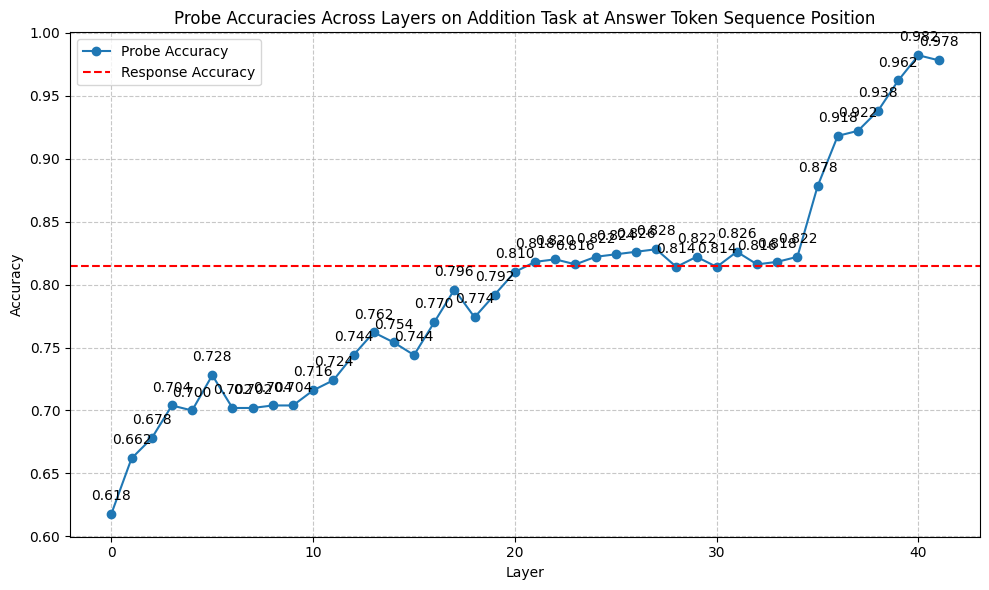

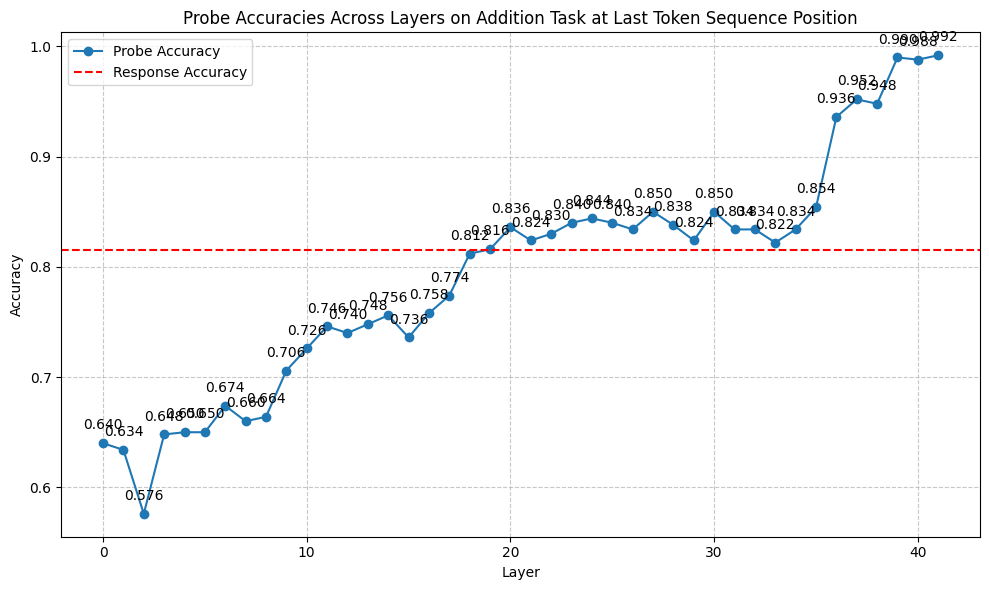

In [24]:
import matplotlib.pyplot as plt

for pos_type, results in results_dict.items():
# Extract layers and accuracies from the results_dict
    layers = list(range(model.cfg.n_layers))
    accuracies = results

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(layers, accuracies, marker='o', label='Probe Accuracy')
    plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Response Accuracy')
    plt.title(f'Probe Accuracies Across Layers on Addition Task at {pos_type} Sequence Position')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, add value labels on the points
    for i, accuracy in enumerate(accuracies):
        plt.annotate(f'{accuracy:.3f}', (layers[i], accuracy), textcoords="offset points", xytext=(0,10), ha='center')

    plt.legend()
    plt.tight_layout()
    plt.show()

### Can we reconstruct linear feature for each operand?

In [48]:
# linear regression
from sklearn.linear_model import LinearRegression
def train_test_linreg(X_train, X_test, y_train, y_test, preprocess=True, return_preds=False):
    # predicting large numbers, but first don't normalize
    if preprocess:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    clf = LinearRegression().fit(X_train, y_train)
    # return clf.score(X_test, y_test)
    pred_test = clf.predict(X_test)
    if return_preds:
        return np.abs(pred_test - y_test).mean(), pred_test
    return np.abs(pred_test - y_test).mean()
    # return np.where(y_test != 0, np.abs((pred_test - y_test) / y_test), np.abs(pred_test)).mean()
    # get difference 

max_num_digits = 1
# get indices of num_digits <= max_num_digits
train_indices = train_df["num_digits"].le(max_num_digits).values
test_indices = test_df["num_digits"].le(max_num_digits).values

pos_type = "Answer Token"
# identify operand1, operand2, and answer
results_dict = {}
predictions_dict = {}
for operand_type in ["operand1", "operand2", "answer", "stated_answer"]:
# for operand_type in ["stated_answer"]:
    if pos_type == "Answer Token":
        X_train = train_answer_pos_acts
        X_test = test_answer_pos_acts
    elif pos_type == "Last Token":
        X_train = train_last_pos_acts
        X_test = test_last_pos_acts

    if operand_type == "stated_answer":
        y_train = np.where(train_df["label"], train_df["answer"], train_df["wrong_answer"])
        y_test = np.where(test_df["label"], test_df["answer"], test_df["wrong_answer"])
    else:
        y_train = train_df[operand_type]
        y_test = test_df[operand_type]
    results_dict[operand_type] = []
    predictions_dict[operand_type] = []
    for layer in tqdm(range(model.cfg.n_layers)):
        # results_dict[operand_type].append(train_test_linreg(X_train[layer], X_test[layer], y_train, y_test))
        mean_abs_error, preds = train_test_linreg(X_train[layer][train_indices], X_test[layer][test_indices], y_train[train_indices], y_test[test_indices], return_preds=True)
        results_dict[operand_type].append(mean_abs_error)
        predictions_dict[operand_type].append(preds)

print(results_dict)

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

{'operand1': [0.6603297004549522, 0.2690941818117157, 0.29233156414482536, 0.19196399553554264, 0.12231674719983199, 0.15022235592519204, 0.12709252853093184, 0.11515106178644136, 0.1668040808730238, 0.18538254077040303, 0.20184689431678593, 0.17543696418521912, 0.17305949541527454, 0.1856476753715455, 0.20624989787424644, 0.2209081912603904, 0.24623013481380432, 0.25318125289256177, 0.23762091876953606, 0.27882096147912694, 0.256950387804527, 0.27910294119767315, 0.25152711793193666, 0.28567008521613174, 0.27005221900038834, 0.2673728146890956, 0.2676709580609179, 0.18992164942223255, 0.21038577688021923, 0.2209509658062552, 0.2189762160533995, 0.2510684475185364, 0.25607968503095974, 0.2627397691171, 0.25111027026739646, 0.2831059290668157, 0.28831407779783713, 0.2806927650932252, 0.2905194214948519, 0.30071454723988933, 0.33333786453787734, 0.33203790319247506], 'operand2': [0.6911589780191737, 0.2245864398836151, 0.22406638137937532, 0.1590959162223996, 0.1103373625147061, 0.178670

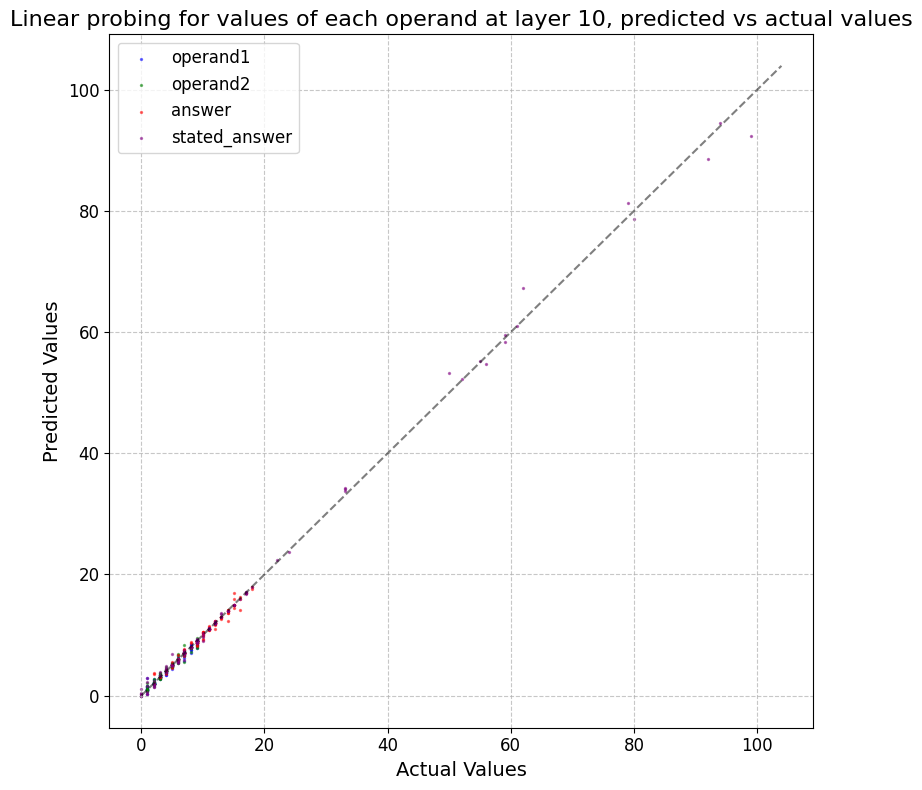

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# def remove_outliers(x, y):
#     # Combine x and y
#     xy = np.vstack((x, y)).T
    
#     # Calculate Z-scores
#     z_scores = stats.zscore(xy)
    
#     # Define outliers as points with absolute Z-score > 3
#     outliers = (np.abs(z_scores) > 3).any(axis=1)
    
#     # Return non-outliers
#     return x[~outliers], y[~outliers]

# Set up the plot
plt.figure(figsize=(8, 8))

# Define colors for each operand type
colors = {'operand1': 'blue', 'operand2': 'green', 'answer': 'red', 'stated_answer': 'purple'}

# Layer to use for predictions (layer 10)
layer_index = 10

# Plot each operand type
for operand_type in ["operand1", "operand2", "answer", "stated_answer"]:
    if operand_type == "stated_answer":
        actual_values = np.where(test_df["label"], test_df["answer"], test_df["wrong_answer"])[test_indices]
    else:
        actual_values = test_df[operand_type][test_indices]
    
    predicted_values = predictions_dict[operand_type][layer_index]
    
    # Remove outliers
    # actual_values, predicted_values = remove_outliers(actual_values, predicted_values)
    
    plt.scatter(actual_values, predicted_values, c=colors[operand_type], alpha=0.5, label=operand_type, s=2)

# Add diagonal line (y=x)
max_value = max(plt.xlim()[1], plt.ylim()[1])
plt.plot([0, max_value], [0, max_value], 'k--', alpha=0.5)

# Customize the plot
plt.title(f'Linear probing for values of each operand at layer {layer_index}, predicted vs actual values', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

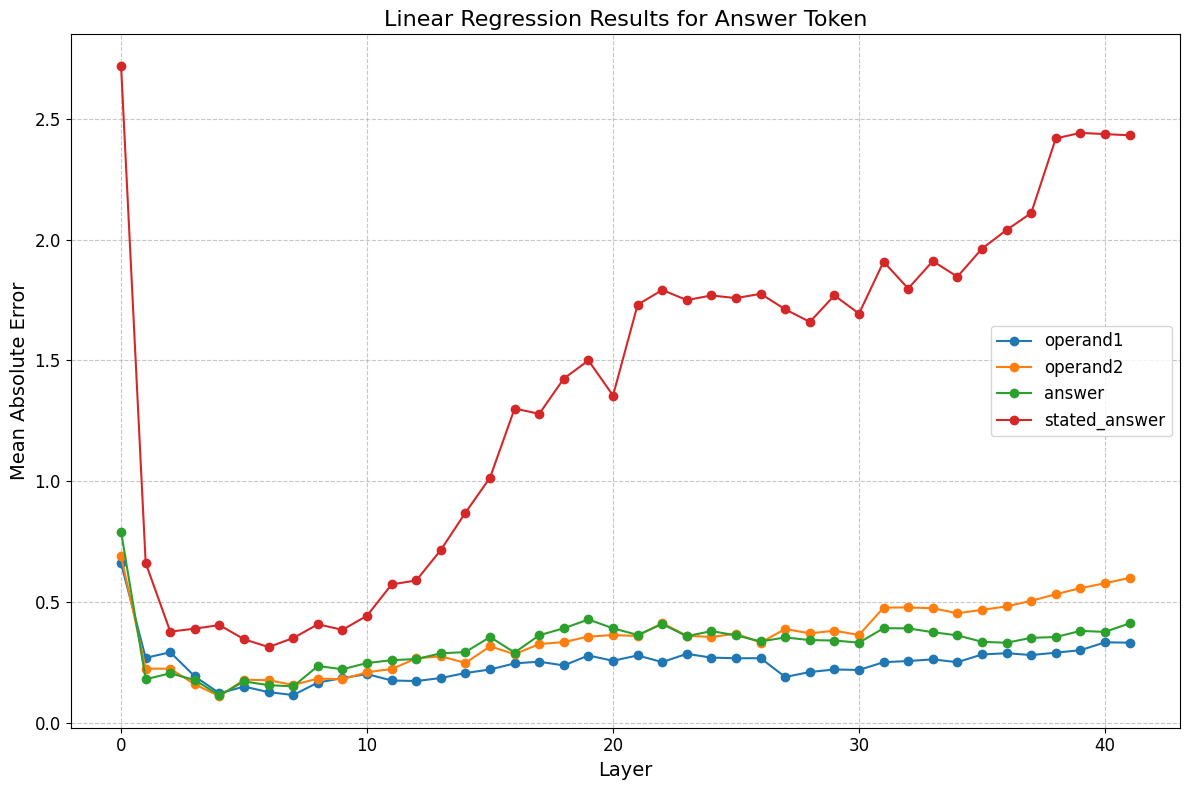

In [50]:
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot each operand type
for operand_type, results in results_dict.items():
    plt.plot(range(len(results)), results, marker='o', label=operand_type)

# Customize the plot
plt.title(f'Linear Regression Results for {pos_type}', fontsize=16)
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Need to 
# 1. Probe for correct sport with no changes
# 2. Probe for correct sport with just <bos>name
# 3. Probe after meal ablating attention heads after layer 2
# 4. Probe after meal ablating attention heads after layer 2 and just <bos>name

def train_test_probe(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
    clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)
    # clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
    # results[layer] = clf.score(X_test, y_test)
    return clf.score(X_test, y_test)

def probe_last_layer(model, prompt_toks, targets, batch_size=None, layer=None):
    if batch_size is None:
        with torch.set_grad_enabled(False):
            _, cache = model.run_with_cache(
            prompt_toks,
            names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post" if layer is None else f"blocks.{layer}.hook_resid_post"
        )
        if layer is not None:
            cache = cache[f"blocks.{layer}.hook_resid_post"][:, -1, :]
        else:
            cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]
    else:
        caches = []
        for i in range(0, prompt_toks.shape[0], batch_size):
            prompt_toks_batch = prompt_toks[i:i+batch_size]
            _, cache = model.run_with_cache(
                prompt_toks_batch,
                names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post" if layer is None else f"blocks.{layer}.hook_resid_post"
            )
            if layer is not None:
                cache = cache[f"blocks.{layer}.hook_resid_post"][:, -1, :]
            else:
                cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]
            caches.append(cache)
        cache = torch.cat(caches, dim=0)
    print("last layer probe, cache shape: ", cache.shape)
    X = cache.cpu().float().numpy()
    print(X.shape, len(targets))
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train logistic regression
    # clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)

    # test_acc = clf.score(X_test, y_test)
    test_acc = train_test_probe(X, y)
    print(f"Accuracy: {test_acc}")

    return test_acc

def probe_across_layers(model, prompt_toks, targets, batch_size=None, cpu_multiprocessing=True):
    print(prompt_toks.shape)
    if batch_size is None:
        with torch.set_grad_enabled(False):
            _, cache = model.run_with_cache(
                prompt_toks,
                names_filter = lambda name: 'resid_post' in name
            )
            cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0) # layer batch d_model
    else:
        caches = []
        for i in range(0, prompt_toks.shape[0], batch_size):
            prompt_toks_batch = prompt_toks[i:i+batch_size]
            with torch.set_grad_enabled(False):
                _, cache = model.run_with_cache(
                    prompt_toks_batch,
                    names_filter = lambda name: 'resid_post' in name
                )
                # print(cache)
                # print(list(cache.values())[0].shape)
                cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0)
                # print(cache.shape)
            caches.append(cache)
        cache = torch.cat(caches, dim=1)
        # print("Batched Cache: ", cache.shape)
    print(f"Cache completed, {cache.shape}")
    results = []
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)

    X_data = {layer: cache[layer].cpu().float().numpy().reshape(-1, cache[layer].shape[-1]) for layer in range(model.cfg.n_layers)}

    results = {}

    if cpu_multiprocessing:
        import multiprocess as mp
        import os
        from multiprocessing import Manager
        from multiprocessing import Pool
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        print("Trying cpu multiprocessing")
        from multiprocessing.dummy import Pool as ThreadPool

        start_time = time.time()
        with ThreadPool(processes=model.cfg.n_layers) as pool:  # Using ThreadPool
            results = pool.starmap(train_test_probe, [(X_data[layer], y) for layer in range(model.cfg.n_layers)])
        end_time = time.time()
        print(f"Time taken: {end_time - start_time} seconds")
        # with Pool(processes=2) as pool:
        #     results = pool.starmap(train_test_probe, [(X_data[layer], y) for layer in range(2)])
        print("finished multiprocessing")
        print(results)
        # Convert list of tuples to dictionary
        results_dict = {layer: results[i] for i, layer in enumerate(range(model.cfg.n_layers))}
        print(results_dict)

        # all_processes = {}
        # for layer in range(1):
        #     m = mp.Process(target=train_test_probe, args=(X_data[layer], y, results))
        #     all_processes[layer] = m
        #     m.start()
        # print(all_processes)
        # for layer in range(1):
        #     all_processes[layer].join()

    else:
        results = []
        start_time = time.time()
        for layer in tqdm(range(model.cfg.n_layers)):
            # print("converting cache")
            # X = cache[layer].cpu().float().numpy().reshape(-1, cache[layer].shape[-1])
            X = X_data[layer]
            # print("cache converted")

            # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
            
            # print("training probe")
            # # train logistic regression
            # clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)
            # print("testing probe")

            # test_acc = clf.score(X_test, y_test)
            # print(f"Layer {layer} Accuracy: {test_acc}")
            # results.append(test_acc)
            test_acc = train_test_probe(X, y)
            results.append(test_acc)
        print(f"Time taken: {time.time() - start_time} seconds")
    return results

def get_mean_cache(model, hook_name="attn_out"):
    pile = iter(load_dataset('monology/pile-uncopyrighted', split='train', streaming=True))
    text = [next(pile)['text'] for i in range(25)]
    toks = torch.stack(
        [
            torch.tensor(tokenizer.encode(t)[:78])
            for t in text
        ],
        dim=0
    )
    with torch.set_grad_enabled(False):
        _, mean_cache = model.run_with_cache(
            toks,
            names_filter = lambda name: any([h_name in name for h_name in [hook_name]])
        )
    return mean_cache


In [ ]:
m_cache = get_mean_cache(model)
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq d_model -> 1 1 d_model',
        'mean'
    )

In [ ]:
mean_cache.keys()

## Basic per-layer probes

In [ ]:
results = {}
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name

model.reset_hooks()
results['Prompt'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist(), batch_size=128, cpu_multiprocessing=True)

model.reset_hooks()
results['Athlete'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist(), batch_size=128)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=5, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(5.3, 0.45, 'Layer 5', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

### Ablate layer heads

In [ ]:
# Add mean ablate hooks
ablate_first_layer = 5

def mean_ablate_hook(act, hook, mean_cache):
    if hook.layer() >= ablate_first_layer:
        print(f'Hooked {hook.name}')
        act = mean_cache[hook.name]
    return act

model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results[f'Prompt + Ablate Heads at Layers >= {ablate_first_layer}'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist(), batch_size=128)

# Add mean ablate hooks
model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results[f'Athlete + Ablate Heads at Layers >= {ablate_first_layer}'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist(), batch_size=128)
model.reset_hooks()

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=5, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(5.3, 0.45, 'Layer 5', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()
print(torch.cuda.mem_get_info())

## Early attention heads

In [ ]:
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name
m_cache = get_mean_cache(model, hook_name="hook_z")
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq head d_model -> 1 1 head d_model',
        'mean'
    )
print(torch.cuda.mem_get_info())

In [ ]:
ablate_first_layer = 5
def act_patch_hook_z(act, hook, patch_cache, patch_layer, patch_head):
    # heads_to_patch is [(layer, head)]
    # heads = [head for layer, head in heads_to_patch if layer == hook.layer()]

    # act is batch head seq d_model

    # want to patch head and every head after layer ablate_first_layer
    if hook.layer() == patch_layer:
        act[:, :, patch_head, :] = patch_cache[hook.name][:, :, patch_head, :]
    elif hook.layer() >= ablate_first_layer:
        act = patch_cache[hook.name]

    return act


layer_range = range(0, ablate_first_layer)
head_range = range(0, model.cfg.n_heads)

heads_to_patch = [
    (layer, head)
    for layer in layer_range
    for head in head_range
]

# Get patch cache
# results_mat = torch.zeros((len(list(layer_range)), len(list(head_range))), device=device)
# for (layer, head) in tqdm(heads_to_patch):
#     # print(f'Patching L{layer}H{head}')

#     model.reset_hooks()

#     model.add_hook(
#         lambda name: 'hook_z' in name,
#         functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=layer, patch_head=head),
#         "fwd"
#     )

#     results_mat[layer, head] += probe_last_layer(model, full_prompt_toks, df['sport'].tolist(), batch_size=64, layer=ablate_first_layer) 

#     model.reset_hooks()
# torch.save(results_mat, f'results/9b_patch_results_{ablate_first_layer=}.pt')

results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')

In [ ]:
# Get baseline accuracy
model.reset_hooks()
model.add_hook(
    lambda name: 'hook_z' in name,
    functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=-1, patch_head=-1),
    "fwd"
)

baseline_acc = probe_last_layer(model, full_prompt_toks, df['sport'].tolist(), layer=ablate_first_layer, batch_size=64) 

model.reset_hooks()

In [ ]:
results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy() - baseline_acc, cmap='RdBu', vmax=.4, vmin=-.4)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Change in Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
fig.savefig(f'results/9b_patch_heatmap_{ablate_first_layer=}.pdf')

In [ ]:
results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy(), cmap='RdBu', vmax=1, vmin=0.5)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
# fig.savefig(f'results/9b_patch_heatmap_{ablate_first_layer=}.pdf')